# Практическое задание

Никонова Юлия Владимировна, 194

### Задача Bike Sharing

Задача на kaggle: https://www.kaggle.com/c/bike-sharing-demand

По историческим данным о прокате велосипедов и погодных условиях необходимо спрогнозировтаь спрос на прокат велосипедов.

В исходной псотановке задачи доступно 9 признаков: https://www.kaggle.com/c/prudential-life-insurance-assessment/data

В наборе признаков присутсвуют вещественные, категориальные, и бинарные данные. 

### Анализ и визуализация данных

In [44]:
from sklearn import cross_validation, ensemble, grid_search, linear_model, metrics, pipeline, preprocessing

import numpy as np
import pandas as pd

In [45]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [46]:
df = pd.read_csv('bike_sharing_train.csv')

In [47]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1


In [48]:
target = df['count']
df.loc[:, ('datetime')] = pd.to_datetime(df.loc[:, ('datetime')].values)

3 . Проанализируйте описание данных:

***datetime*** - hourly date + timestamp  

***season*** -  1 = spring, 2 = summer, 3 = fall, 4 = winter 

***holiday*** - whether the day is considered a holiday

***workingday*** - whether the day is neither a weekend nor holiday

***weather*** - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
    
***temp*** - temperature in Celsius

***atemp*** - "feels like" temperature in Celsius

***humidity*** - relative humidity

***windspeed*** - wind speed

***count*** - number of total rentals

weather, atemp

holiday

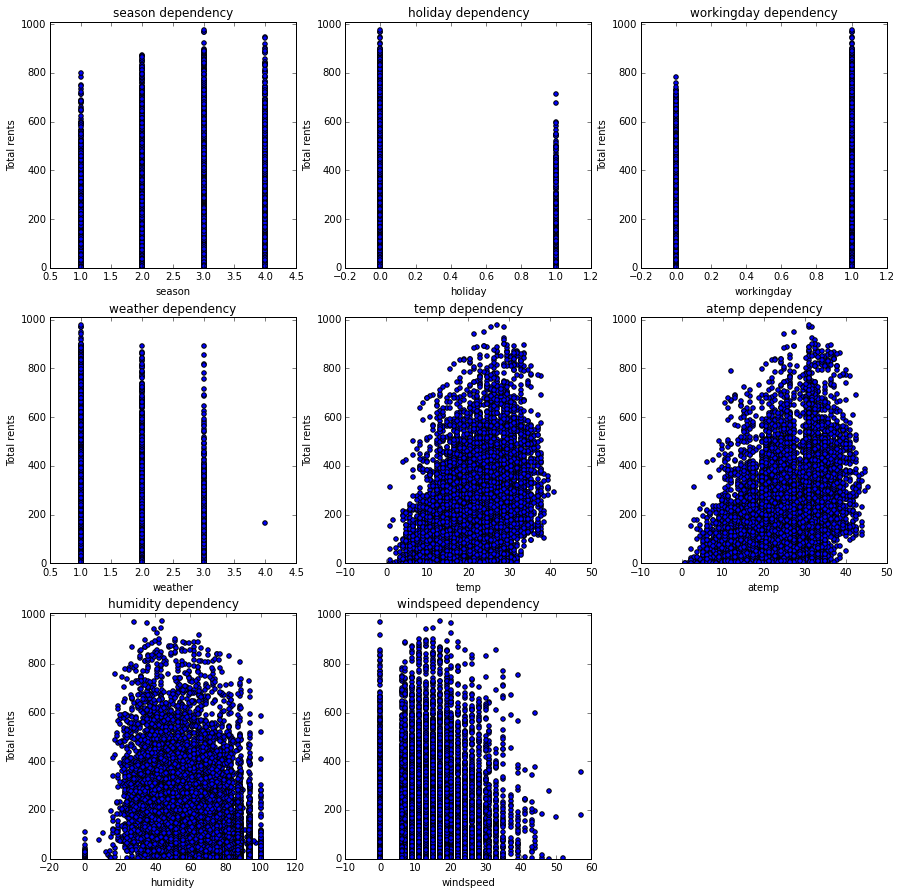

In [49]:
y = target.values
fig = plt.figure(figsize=(15,15), dpi=1000)

for (index, column) in enumerate(df.columns[1:-1]):
    plt.subplot(3,3,index+1)
    plt.scatter(df[column].values, y)
    plt.ylim(0, 1010)
    plt.xlabel(column)
    plt.ylabel('Total rents')
    plt.title("{} dependency".format(column))


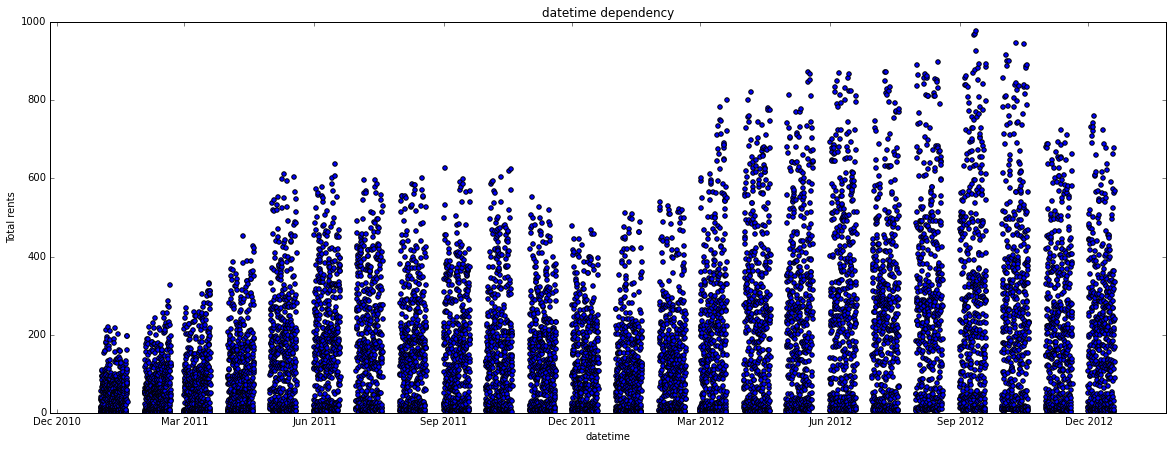

In [50]:
fig = plt.figure(figsize=(20,7), dpi=3000)
plt.scatter(df['datetime'].values, y)
plt.ylim((0, 1000))
plt.xlabel('datetime')
plt.ylabel('Total rents')
plt.title("{} dependency".format('datetime'))

Прокат пользовался большим спросом в 2012 году. Прокат пользуется большим спросом в рабочие дни, при погоде без осадков, при умеренно теплой температуре.

In [51]:
df.corr()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.163439
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,-0.005393
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,0.011594
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.128655
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.394454
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.389784
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.317371
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.101369
count,0.163439,-0.005393,0.011594,-0.128655,0.394454,0.389784,-0.317371,0.101369,1.000000


Очень сильно скоррелированны temp и atemp, коррелируют между собой weather и humidity, temp и season. С целевой функцией коррелируют temp, atemn, humidity.

In [52]:
for column in df.columns[1:-1]:
    print "{} mean={:.3f} std={:.3f}".format(column, df[column].mean(), df[column].std())

season mean=2.507 std=1.116
holiday mean=0.029 std=0.167
workingday mean=0.681 std=0.466
weather mean=1.418 std=0.634
temp mean=20.231 std=7.792
atemp mean=23.655 std=8.475
humidity mean=61.886 std=19.245
windspeed mean=12.799 std=8.165


Признаки имеют разный масштаб, при линейные классификаторы при классификации будут давать большие веса признакам большего масштаба, что ухудшает качество.

### Линейные модели

In [53]:
test_size = 0.3
train_size = 1 - test_size
train_indices = range(0, int(len(df) * train_size))
test_indices = range(int(len(df) * train_size), len(df))
train_data = df.iloc[train_indices, 1:-1]
train_labels = df.iloc[train_indices, -1].values
test_data = df.iloc[test_indices, 1:-1]
test_data.index = range(0, len(test_data))
test_labels = df.iloc[test_indices, -1].values

In [54]:
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(train_data)
X_test = scaler.fit_transform(test_data)

In [55]:
def test_clf(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    train_prediction = clf.predict(X_train)
    test_prediction = clf.predict(X_test)
    return metrics.mean_absolute_error(y_train, train_prediction), metrics.mean_absolute_error(y_test, test_prediction)
    
sgd = linear_model.SGDRegressor()
lasso = linear_model.Lasso()
print "SGD: train_mae={:.3f} test_mae={:.3f}".format(*test_clf(sgd, X_train, train_labels, X_test, test_labels)) 
print "Lasso: train_mae={:.3f} test_mae={:.3f}".format(*test_clf(lasso, X_train, train_labels, X_test, test_labels)) 

SGD: train_mae=97.827 test_mae=162.042
Lasso: train_mae=98.032 test_mae=162.377


Видно, что качество на тесте значительно хуже, чем на обучении для обоих классификаторов, качество классификаторов практически одинаковое.

In [56]:
def print_feautures_characteristic(coefs, features, characteristic):
    indices = np.argsort(coefs)[::-1]
    for index in indices:
        if index < len(features):
            feature_name =  features[index]
        else:
            feature_name = index
        print "{} {} = {:.3f}".format(feature_name, characteristic, coefs[index])
print "Lasso:"
print_feautures_characteristic(lasso.coef_, train_data.columns.values, 'coefficent')
print "SGD:"
print_feautures_characteristic(sgd.coef_, train_data.columns.values, 'coefficent')

Lasso:
atemp coefficent = 58.718
windspeed coefficent = 4.383
season coefficent = 3.512
temp coefficent = 0.000
weather coefficent = -0.000
holiday coefficent = -0.557
workingday coefficent = -1.192
humidity coefficent = -43.509
SGD:
atemp coefficent = 45.342
temp coefficent = 14.812
season coefficent = 5.543
windspeed coefficent = 5.323
weather coefficent = 1.424
holiday coefficent = 0.200
workingday coefficent = -1.374
humidity coefficent = -44.478


Наибольший вклад в модель внесли atemp и humidity.

In [57]:
# Пример:
# train_data, train_labels - DataFrame с обучающей выборкой и значения целевой функции на обучении
# test_data, test_labels - DataFrame с тестовой выборкой и значения целевой функции на тесте

# Создание индекса для бинарных признаков
binary_data_columns = ['holiday', 'workingday']
binary_data_indices = np.array([(column in binary_data_columns) for column in train_data.columns], dtype = bool)

# Создание индекса для вещественных признаков
numeric_data_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'season', 'weather']
numeric_data_indices = np.array([(column in numeric_data_columns) for column in train_data.columns], dtype = bool)

# Создание модели регресии
model = linear_model.SGDRegressor(random_state = 0)

# Объявление pipline -  цепочки преобразования данных, начиная от обработки данных в зависимости от их типа, и 
# заканчивая обучением модели. 

estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler())            
                        ])),

        ])),
    ('model_fitting', model)
    ]
)

# С цепочкой можно работать как с одиночным преобразованием, в частности вызывать методы fit и predict 
estimator.fit(train_data, train_labels)
metrics.mean_absolute_error(test_labels, estimator.predict(test_data))

154.71408979224472

In [58]:
# Создание индекса для бинарных признаков
binary_data_columns = ['holiday', 'workingday']
binary_data_indices = np.array([(column in binary_data_columns) for column in train_data.columns], dtype = bool)

# Создание индекса для вещественных признаков
numeric_data_columns = ['temp', 'atemp', 'humidity', 'windspeed']
numeric_data_indices = np.array([(column in numeric_data_columns) for column in train_data.columns], dtype = bool)

# Создание индекса для категориальных признаков
categorical_data_columns = ['weather', 'season']
categorical_data_indices = np.array([(column in categorical_data_columns) for column in train_data.columns], dtype = bool)

# Создание модели регресии
model = linear_model.SGDRegressor(random_state = 0)


binary_variables_processing = preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])
numeric_variables_processing = pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler())            
                        ])


categorical_variables_processing = pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices])),
                ('encoding', preprocessing.OneHotEncoder(sparse=True, handle_unknown='ignore'))            
                        ])

# Объявление pipline -  цепочки преобразования данных, начиная от обработки данных в зависимости от их типа, и 
# заканчивая обучением модели. 

estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', binary_variables_processing), 
                    
            #numeric
            ('numeric_variables_processing', numeric_variables_processing),
                    
            #categorical
            ('categorical_variables_processing', categorical_variables_processing)

        ])),
    ('model_fitting', model)
    ]
)

# С цепочкой можно работать как с одиночным преобразованием, в частности вызывать методы fit и predict 
estimator.fit(train_data, train_labels)
metrics.mean_absolute_error(test_labels, estimator.predict(test_data))

153.22725737498848

Обработка признаков улучшила качество модели

In [59]:
from sklearn.grid_search import RandomizedSearchCV
from sklearn.grid_search import GridSearchCV
parameters = {
    'model_fitting__loss': ('squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'),
    'model_fitting__penalty': ('l2', 'elasticnet', 'l1'),
    'model_fitting__alpha': (0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000)
}

random_search = RandomizedSearchCV(estimator, parameters, n_iter=50)
random_search.fit(train_data, train_labels)
metrics.mean_absolute_error(test_labels, random_search.predict(test_data))

156.39687416532496

Подбор параметров не улучшил качество модели

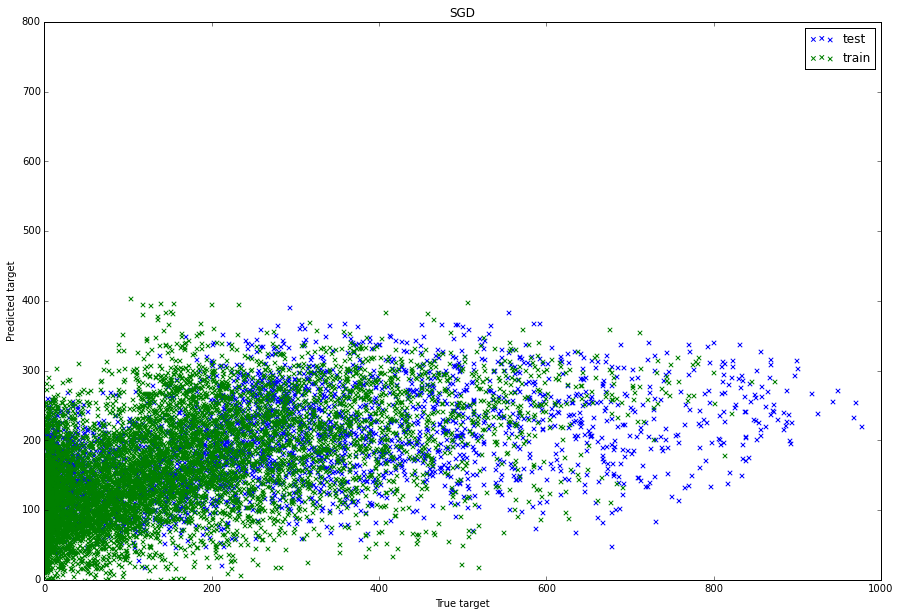

In [60]:
fig = plt.figure(figsize=(15,10), dpi=3000)
plt.scatter(test_labels, estimator.predict(test_data), marker='x', label='test')
plt.scatter(train_labels, estimator.predict(train_data), color='green', marker='x', label='train')
plt.xlim((0, 1000))
plt.ylim((0, 800))
plt.xlabel('True target')
plt.ylabel('Predicted target')
plt.legend(loc='best')
plt.title('SGD')

На основе построенного графика можно сделать вывод, что мы получили модель, которая плохо предсказывает целевую функцию и на обучении, и на тесте, так как в случае хорошего классификатора точки были бы сосредоточены около прямой $y=x$.

### Случайный лес

In [61]:
model = ensemble.RandomForestRegressor()

estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', binary_variables_processing), 
                    
            #numeric
            ('numeric_variables_processing', numeric_variables_processing),
                    
            #categorical
            ('categorical_variables_processing', categorical_variables_processing)

        ])),
    ('model_fitting', model)
    ]
)

 
estimator.fit(train_data, train_labels)
print "{}:\ntest_mae = {}\ntrain_mae={}".format("Random forest", 
                                                 metrics.mean_absolute_error(train_labels, estimator.predict(train_data)),
                                                 metrics.mean_absolute_error(test_labels, estimator.predict(test_data)))


Random forest:
test_mae = 40.9515073541
train_mae=154.309456881


Качество на обучении значительно улучшилось в сравнении с линейными классификаторами, а на обучении не улучшилось.

In [65]:
labeldummy, rf = estimator.steps[-1] 
print "Random forest:"
print_feautures_characteristic(rf.feature_importances_ , train_data.columns.values, 'importance')

Random forest:
temp importance = 0.281
atemp importance = 0.195
workingday importance = 0.194
weather importance = 0.166
holiday importance = 0.041
humidity importance = 0.021
windspeed importance = 0.020
10 importance = 0.019
11 importance = 0.019
9 importance = 0.016
8 importance = 0.014
12 importance = 0.009
season importance = 0.006
13 importance = 0.000


Наибольший вклад оказали temp, atemp и workingday. Это не очень соответсвует моим предсавлениям о вкладе признаков.

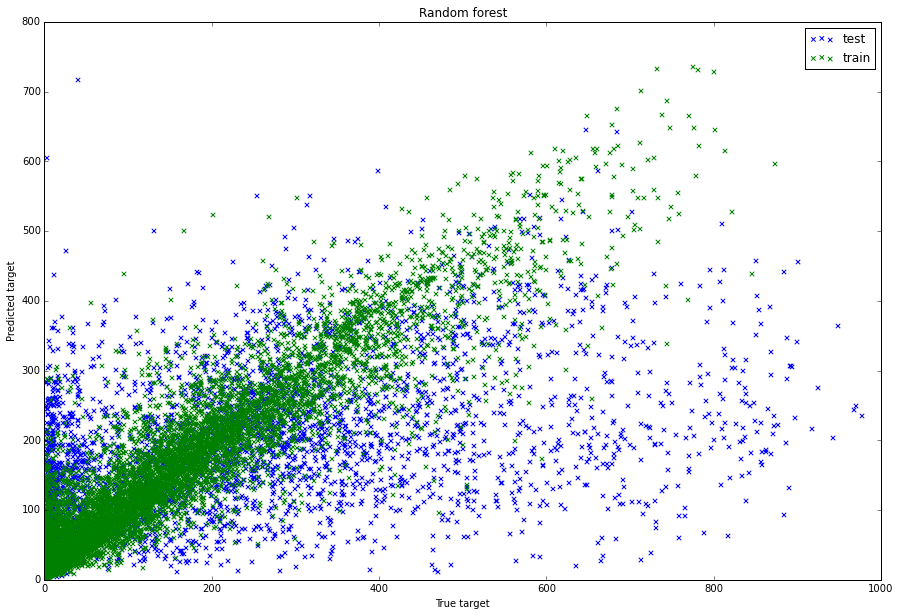

In [67]:
fig = plt.figure(figsize=(15,10), dpi=3000)
plt.scatter(test_labels, estimator.predict(test_data), marker='x', label='test')
plt.scatter(train_labels, estimator.predict(train_data), color='green', marker='x', label='train')
plt.xlim((0, 1000))
plt.ylim((0, 800))
plt.xlabel('True target')
plt.ylabel('Predicted target')
plt.legend(loc='best')
plt.title('Random forest')

Видно, что на обучении качество значительно улучшилось, график для обучения стал более сконцентрирован около прямой $y=x$, на тесте же качество не улучшилось. 

### Опциональная часть

Попробуйте улучшить результат, полученный на предыдущих шагах. В этом разделе можно и нужно пользоваться любыми изученными алгоритмами, инструментами и всем, чем вам захочется.

### Заключение

В этом разделе Вы можете написать, какие выводы Вы сделали в процессе работы над заданием, понравилось ли оно Вам, а также всё, что Вы о задании думаете =)